In [1]:
# General imports
import numpy as np
import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import DensityMatrix, partial_trace
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator

from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

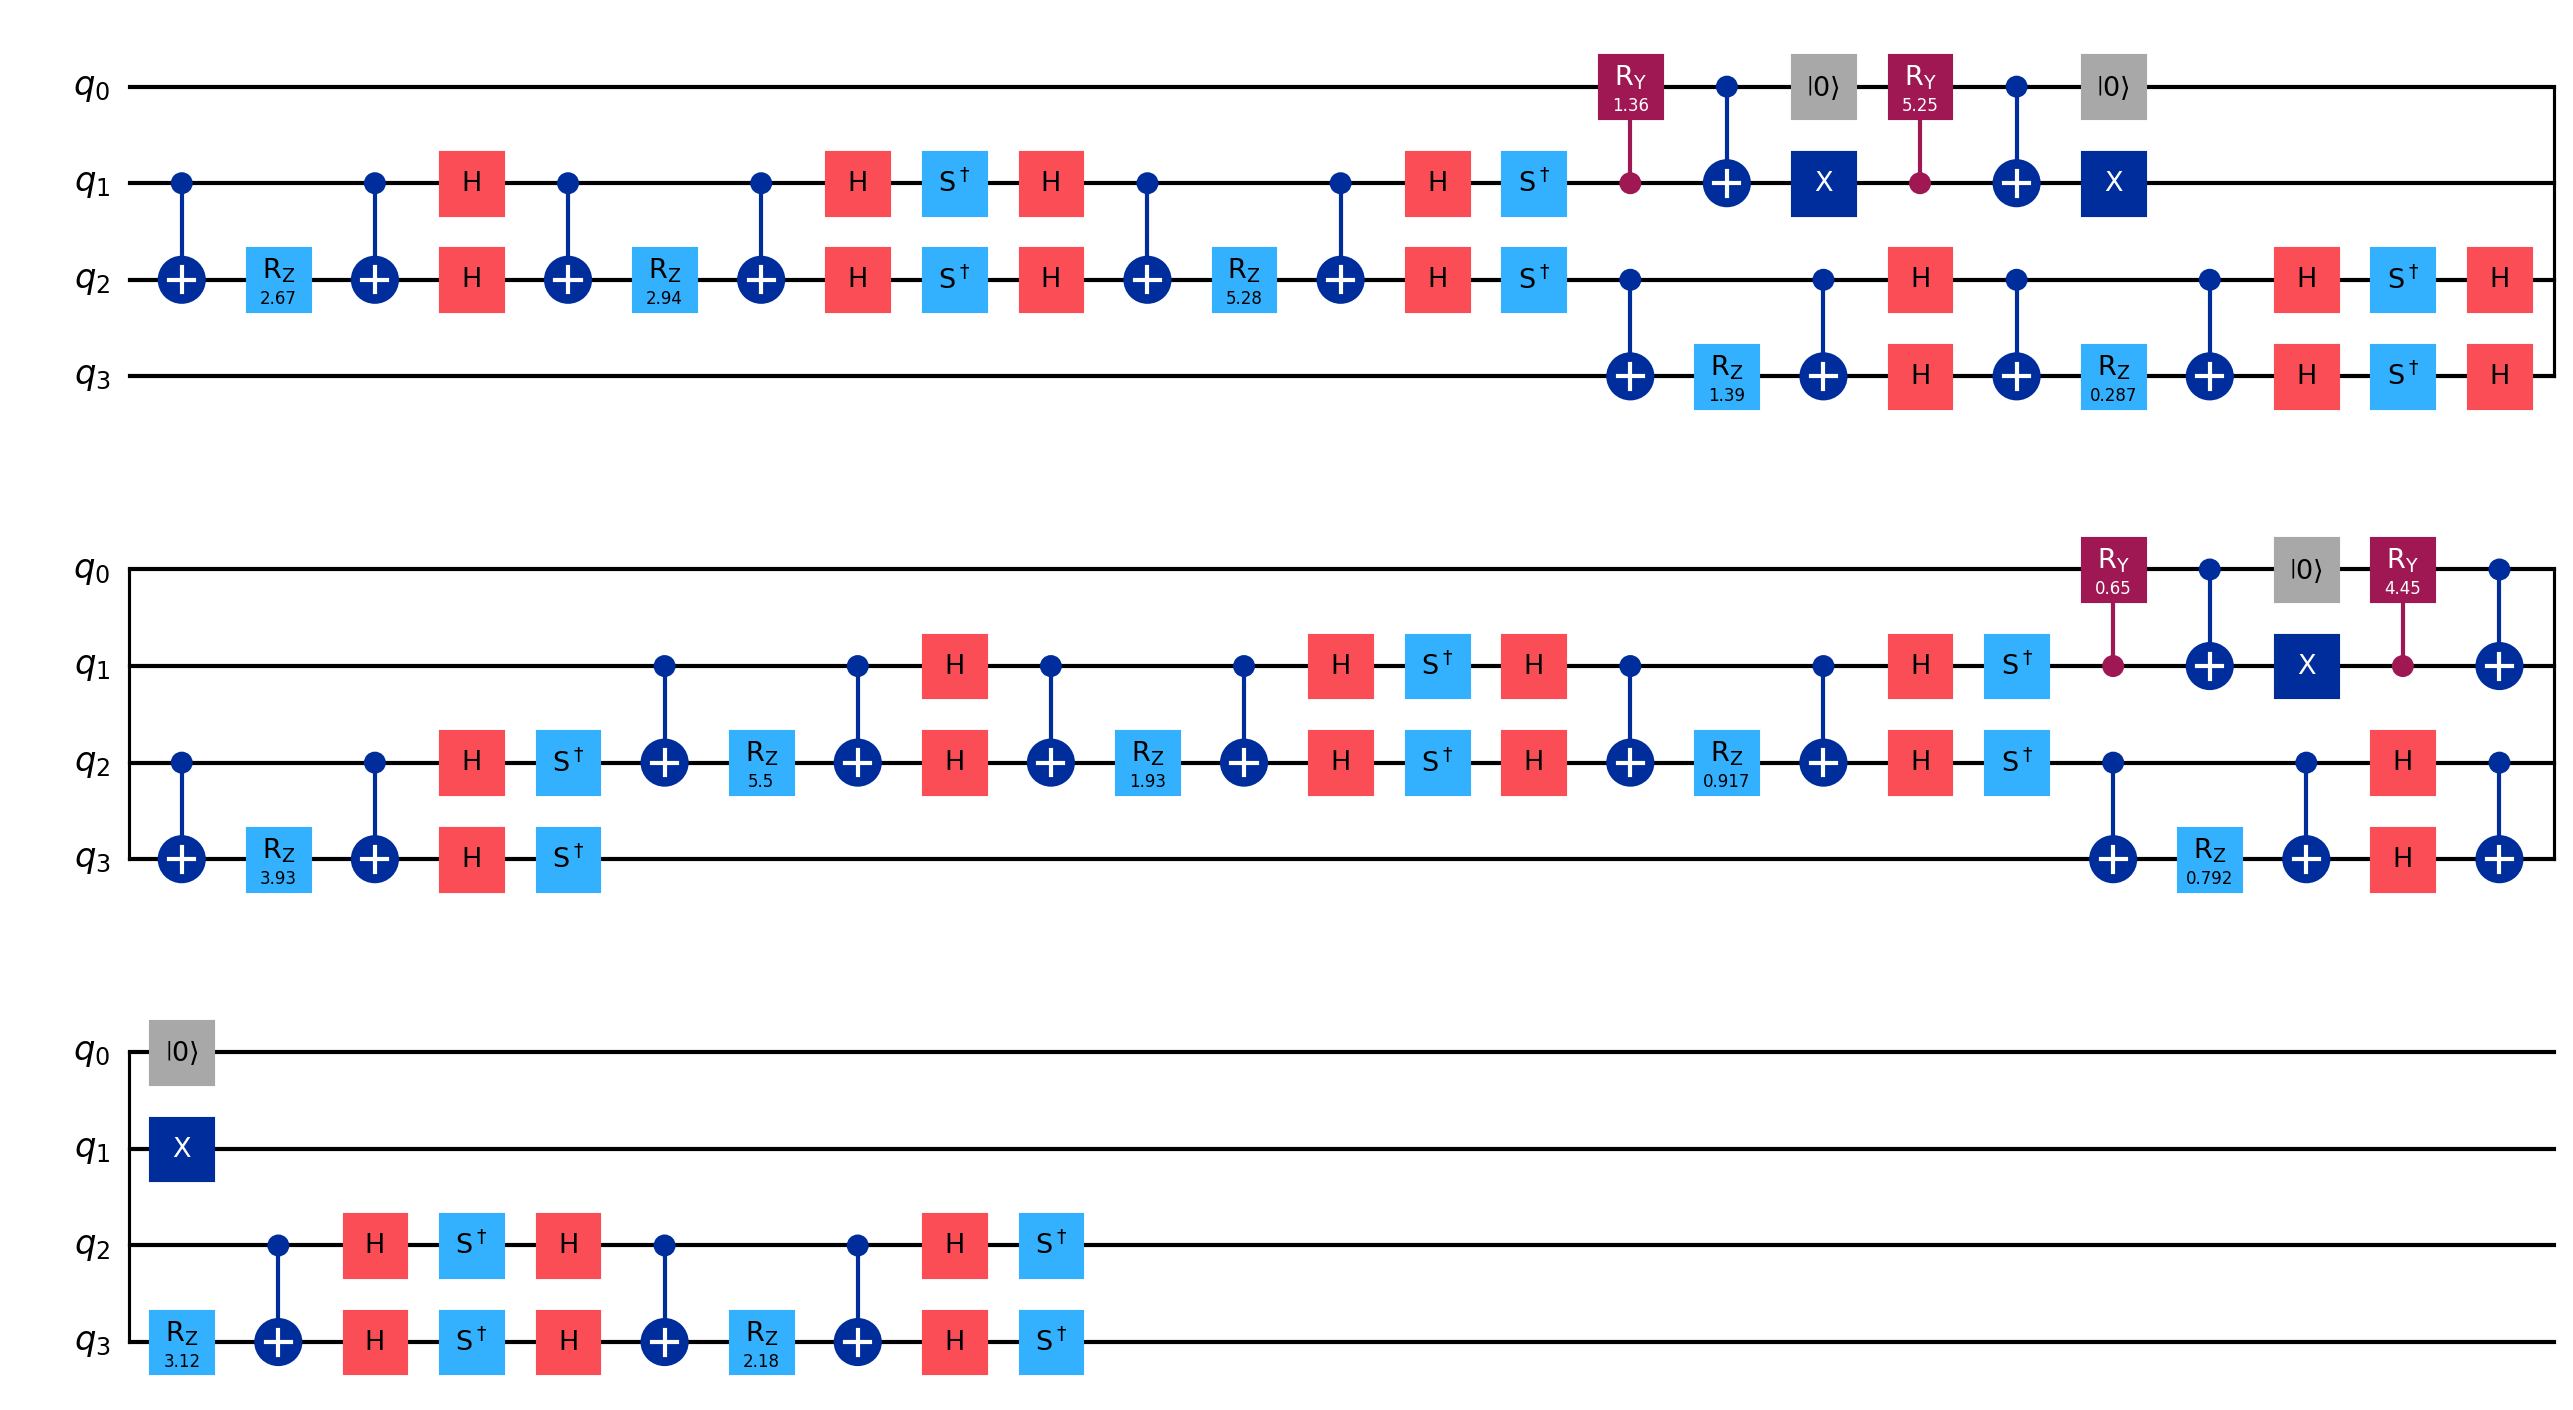

In [5]:
# VQA circuit.
from qiskit import QuantumCircuit, transpile

# Pauli matrices and identity (sparse format)
I = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

"""
The TFIM for L = 2 is given by: H = J * (Z_1 * Z_2) + h * (X_1 + X_2). We will consider
the two jump operators: L_1 = sqrt(g_1) * (X_1 - i * Y_1} and L_2 = sqrt(g_2) * (X_2 - i Y_2).

"""

# The variational circuit is just the trotter circuit for the TFIM.
n_qubits = 3
def anstaz_circuit(angles_lst, number_of_layers):  

     number_of_angles_per_layer = 8

     if len(angles_lst*number_of_angles_per_layer) % number_of_layers != 0:
         raise ValueError("The number of angles should be divisible by the number of layers.")
     else:
           anstaz_circuit = QuantumCircuit(n_qubits+1)
           for i in range(number_of_layers):
               # Hamiltonian part.
               # Z_1 Z_2.
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rz(angles_lst[i][0], 2)
               anstaz_circuit.cx(1,2)
               # X_1 X_2.
               anstaz_circuit.h(1)
               anstaz_circuit.h(2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rz(angles_lst[i][1], 2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.h(1)
               anstaz_circuit.h(2)
               # Y_1 Y_2.
               anstaz_circuit.sdg(1)
               anstaz_circuit.h(1)
               anstaz_circuit.sdg(2)
               anstaz_circuit.h(2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rz(angles_lst[i][2], 2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.h(1)
               anstaz_circuit.h(2)
               anstaz_circuit.sdg(1)
               anstaz_circuit.sdg(2)

               # Z_2 Z_3.
               anstaz_circuit.cx(2,3)
               anstaz_circuit.rz(angles_lst[i][3], 3)
               anstaz_circuit.cx(2,3)
               # X_2 X_3
               anstaz_circuit.h(2)
               anstaz_circuit.h(3)
               anstaz_circuit.cx(2,3)
               anstaz_circuit.rz(angles_lst[i][4], 3)
               anstaz_circuit.cx(2,3)
               anstaz_circuit.h(2)
               anstaz_circuit.h(3)
               # Y_2 Y_3.
               anstaz_circuit.sdg(2)
               anstaz_circuit.h(2)
               anstaz_circuit.sdg(3)
               anstaz_circuit.h(3)
               anstaz_circuit.cx(2,3)
               anstaz_circuit.rz(angles_lst[i][5], 3)
               anstaz_circuit.cx(2,3)
               anstaz_circuit.h(2)
               anstaz_circuit.h(3)
               anstaz_circuit.sdg(2)
               anstaz_circuit.sdg(3)

               # Jump operator part.
               anstaz_circuit.cry(angles_lst[i][6], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.reset(0)
               anstaz_circuit.x(1)
               anstaz_circuit.cry(angles_lst[i][7], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.x(1)
               anstaz_circuit.reset(0)

     return anstaz_circuit      

anstaz_circuit([[np.random.uniform(0, 2*np.pi) for i in range(8)] for j in range(2)], 2).draw("mpl", scale = 1.5)     

In [6]:
J = 1.0
h = 1.0
gamma_1 = 1
gamma_2 = 0.5

# Hilbert space dimension for L = 3
dim = 2**3  # 2^L where L = 3

# Hamiltonian of the Heisenberg model with L = 3
def build_hamiltonian():
    H = J * (
        kron(kron(sigma_x, sigma_x), I)
        + kron(kron(sigma_y, sigma_y), I)
        + kron(kron(sigma_z, sigma_z), I)
        + kron(kron(I, sigma_x), sigma_x)
        + kron(kron(I, sigma_y), sigma_y)
        + kron(kron(I, sigma_z), sigma_z)
    )
    H += h * (
        kron(kron(sigma_x, I), I)
        + kron(kron(I, sigma_x), I)
        + kron(kron(I, I), sigma_x)
    )
    return H

# Jump operators
def build_jump_operators():
    L_1 = np.sqrt(gamma_1) * (kron(kron(sigma_x, I), I) - 1j * kron(kron(sigma_y, I), I))
    L_2 = np.sqrt(gamma_2) * (kron(kron(sigma_x, I), I) + 1j * kron(kron(sigma_y, I), I))
    return L_1, L_2

# Lindblad equation
def lindblad_equation(rho):
    # Ensure rho is an (8x8) matrix
    rho = csr_matrix(rho)

    # Build Hamiltonian and jump operators
    H = build_hamiltonian()
    L_1, L_2 = build_jump_operators()

    # Commutator: -i [H, rho]
    commutator = -1j * (H @ rho - rho @ H)

    # Lindblad dissipator terms
    lindblad_1 = L_1 @ rho @ L_1.getH() - 0.5 * (L_1.getH() @ L_1 @ rho + rho @ L_1.getH() @ L_1)
    lindblad_2 = L_2 @ rho @ L_2.getH() - 0.5 * (L_2.getH() @ L_2 @ rho + rho @ L_2.getH() @ L_2)

    d_rho_dt = commutator + lindblad_1 + lindblad_2
    return d_rho_dt

# Cost function
def cost_function(rho):
    L_rho = lindblad_equation(rho)
    return np.real(np.trace(L_rho.conj().T @ L_rho.toarray()))

In [7]:
def return_density_matrix(quantum_circuit):

     quantum_circuit.save_density_matrix()  # Save the density matrix

     # Step 2: Simulate the circuit
     simulator = AerSimulator()  # Aer simulator supports reset gates
     quantum_circuit = transpile(quantum_circuit, simulator)
     result = simulator.run(quantum_circuit).result()
     # Step 3: Extract the density matrix
     rho_full = DensityMatrix(result.data()["density_matrix"])

     # Step 4: Compute the reduced density matrix for the second qubit
     rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
     rho_1_matrix = rho_1.data

     return rho_1_matrix

In [8]:
def update_angles(current_angles_lst, number_of_layers, learning_rate):
     # Shift each angle by + pi/2.
     angles_plus = current_angles_lst.copy()
     for i in range(number_of_layers):
          for j in range(8):
               angles_plus[i][j] += np.pi/2
     # Shift each angle by - pi/2.
     angles_minus = current_angles_lst.copy()
     for i in range(number_of_layers):
          for j in range(8):
               angles_minus[i][j] -= np.pi/2
     # Compute the cost function for the  angles_plus and angles_minus.
     cost_plus = cost_function(return_density_matrix(anstaz_circuit(angles_plus, number_of_layers)))
     cost_minus = cost_function(return_density_matrix(anstaz_circuit(angles_minus, number_of_layers)))
     # Compute the gradient.
     gradient = (cost_plus - cost_minus)/2
     # Update the angles for each layer and each angle.
     updated_angles = current_angles_lst.copy()
     for i in range(number_of_layers):
          for j in range(8):
               updated_angles[i][j] -= learning_rate * gradient
     return updated_angles

In [28]:
initial_learning_rate = 5
number_of_layers = 2
number_of_iteration = 0
max_iterations = 100
best_cost = float("inf")

tolerance_for_convergence = 1e-2
initial_angles_lst = [[np.random.uniform(0, 2*np.pi) for i in range(8)] for j in range(number_of_layers)]
print("Initial angles: ", initial_angles_lst)
angles_lst = initial_angles_lst
best_angles_lst = initial_angles_lst
best_iteration = 0
cost_function_values_lst = []

while number_of_iteration < max_iterations:
     vqa_circuit = anstaz_circuit(angles_lst, number_of_layers)
     rho = return_density_matrix(vqa_circuit)
     cost_value = cost_function(rho)
     print("Cost value: ", cost_value)
     cost_function_values_lst.append(cost_value)

     if cost_value < best_cost:
          best_cost = cost_value
          best_angles_lst = angles_lst
          best_iteration = number_of_iteration
     if cost_value < tolerance_for_convergence:
          print("The optimization has converged.")
          print("Best cost value: ", best_cost)
          print("Best angles: ", best_angles_lst)
          break

     learning_rate = initial_learning_rate/(number_of_iteration + 1)

     angles_lst = update_angles(angles_lst, number_of_layers, learning_rate)
     number_of_iteration += 1
     print("Number of iteration: ", number_of_iteration)
     print("Cost value: ", cost_value)
     print("Learning rate: ", learning_rate)

     if number_of_iteration == max_iterations:
          print("The optimization has not converged.")
          print("Best cost value: ", best_cost)
          print("Best angles: ", best_angles_lst)
          break

Initial angles:  [[3.9099519437164374, 6.18716359183253, 1.02321665439504, 0.690841504583538, 3.9630597974568023, 3.653783913049282, 3.7962163264301476, 3.4175450880364027], [1.2336659415986253, 1.9647649232275652, 5.750947403285879, 3.267142527368092, 3.7833326954303166, 0.05621152026714609, 6.172611267123826, 2.092397384407336]]
Cost value:  4.665427944562932
Number of iteration:  1
Cost value:  4.665427944562932
Learning rate:  5.0
Cost value:  8.624600097986182
Number of iteration:  2
Cost value:  8.624600097986182
Learning rate:  2.5
Cost value:  3.7893109405068484
Number of iteration:  3
Cost value:  3.7893109405068484
Learning rate:  1.6666666666666667
Cost value:  4.9697985340817645
Number of iteration:  4
Cost value:  4.9697985340817645
Learning rate:  1.25
Cost value:  4.335489730164038
Number of iteration:  5
Cost value:  4.335489730164038
Learning rate:  1.0
Cost value:  5.921750205898056
Number of iteration:  6
Cost value:  5.921750205898056
Learning rate:  0.8333333333333

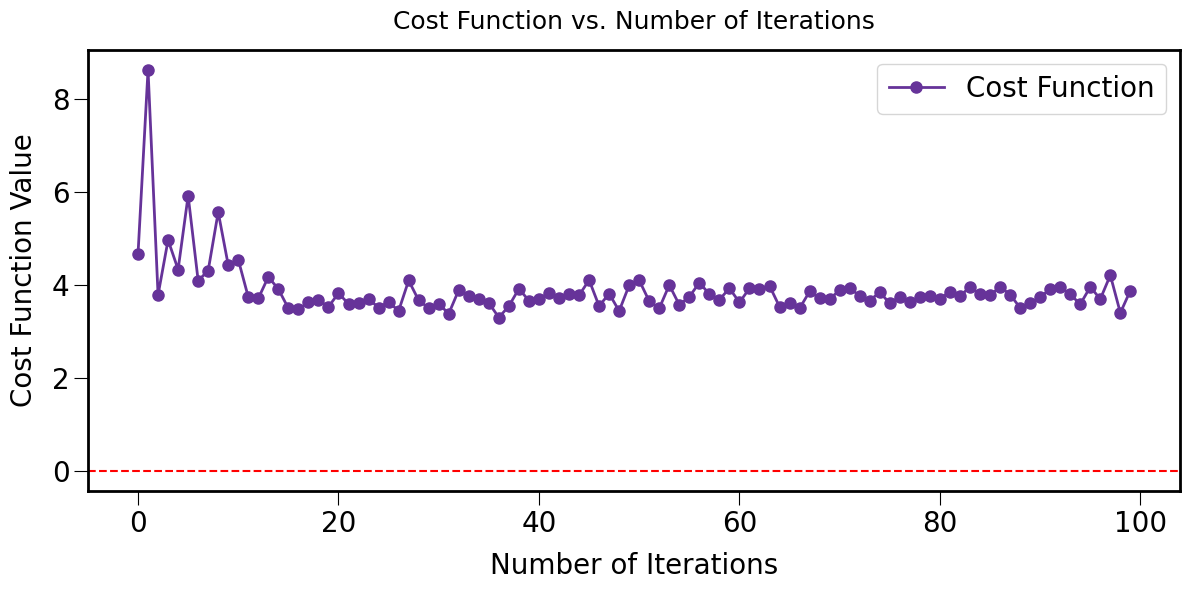

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(cost_function_values_lst)), cost_function_values_lst, marker="o", linestyle='-', color="rebeccapurple", linewidth=2, markersize=8, label="Cost Function")
plt.xlabel("Number of Iterations", fontsize=20, labelpad=10)
plt.ylabel("Cost Function Value", fontsize=20, labelpad=10)
plt.title("Cost Function vs. Number of Iterations", fontsize=18, pad=15)
#plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color="r", linestyle="--")
# Get current axis
ax = plt.gca()
# Make axis lines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
# Make ticks longer
ax.tick_params(axis='both', which='major', length=10)
plt.tight_layout()
#plt.axhline(y=0.8, color="r", linestyle="--")
plt.show()